# CS 4120 - Song Genre Classification

We are compare the performance of __INSERT MODELS__ for the task of classifying songs by genre.

## Dataset

We use a [Kaggle dataset](https://www.kaggle.com/datasets/neisse/scrapped-lyrics-from-6-genres?resource=download&select=lyrics-data.csv) with data on many artists and songs originally scraped from Vagalume.com.
Since the dataset associates artists with songs and their lyrics, then genres with artists separately, we join the two datasets in order to make associations between genres and lyrics in order to obtain data to train our models.

## Getting Started

From the Kaggle dataset (linked above), download `artists-data.csv` to `data/artists-data.csv` and `lyrics-data.csv` to `data/lyrics-data.csv`.
Install all the packages imported in the following cell.

In [41]:
%%capture
import pandas as pd
import nltk
import numpy as np
import string
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('words', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Data Preprocessing

In [42]:
# suppress some warnings in cell output
pd.options.mode.chained_assignment = None  # default='warn'

In [43]:
# Import Song Data

song_data = pd.read_csv('./data/lyrics-data.csv')
english_songs = song_data.loc[song_data['language'] == 'en']
english_songs.rename(columns={'ALink':'Link'}, inplace=True)
english_songs.head()

,Link,SName,SLink,Lyric,language
69,/ivete-sangalo/,Careless Whisper,/ivete-sangalo/careless-whisper.html,I feel so unsure\nAs I take your hand and lead...,en
86,/ivete-sangalo/,Could You Be Loved / Citação Musical do Rap: S...,/ivete-sangalo/could-you-be-loved-citacao-musi...,"Don't let them fool, ya\nOr even try to school...",en
88,/ivete-sangalo/,Cruisin' (Part. Saulo),/ivete-sangalo/cruisin-part-saulo.html,"Baby, let's cruise, away from here\nDon't be c...",en
111,/ivete-sangalo/,Easy,/ivete-sangalo/easy.html,"Know it sounds funny\nBut, I just can't stand ...",en
140,/ivete-sangalo/,For Your Babies (The Voice cover),/ivete-sangalo/for-your-babies-the-voice-cover...,You've got that look again\nThe one I hoped I ...,en


In [44]:
# Import Artist Data

artist_data = pd.read_csv('./data/artists-data.csv')
artist_data = artist_data.drop_duplicates(subset='Link', keep='first')
artist_data.head()

,Artist,Genres,Songs,Popularity,Link
0,Ivete Sangalo,Pop; Axé; Romântico,313.0,4.4,/ivete-sangalo/
1,Chiclete com Banana,Axé,268.0,3.8,/chiclete-com-banana/
2,Banda Eva,Axé; Romântico; Reggae,215.0,2.3,/banda-eva/
3,É O Tchan,Axé,129.0,1.6,/e-o-tchan/
4,Claudia Leitte,Pop; Axé; Romântico,167.0,1.5,/claudia-leitte/


In [45]:
# Merge Dataframes

combined_data = pd.merge(english_songs, artist_data, on='Link')
combined_data = combined_data[["SName", "Artist", "Lyric", "Genres"]]
combined_data = combined_data[combined_data.Lyric.notnull()]
combined_data = combined_data[combined_data.Genres.notnull()]
combined_data

,SName,Artist,Lyric,Genres
0,Careless Whisper,Ivete Sangalo,I feel so unsure\nAs I take your hand and lead...,Pop; Axé; Romântico
1,Could You Be Loved / Citação Musical do Rap: S...,Ivete Sangalo,"Don't let them fool, ya\nOr even try to school...",Pop; Axé; Romântico
2,Cruisin' (Part. Saulo),Ivete Sangalo,"Baby, let's cruise, away from here\nDon't be c...",Pop; Axé; Romântico
3,Easy,Ivete Sangalo,"Know it sounds funny\nBut, I just can't stand ...",Pop; Axé; Romântico
4,For Your Babies (The Voice cover),Ivete Sangalo,You've got that look again\nThe one I hoped I ...,Pop; Axé; Romântico
...,...,...,...,...
191382,The Waiting,Johnny Clegg,Chorus\nHere we stand waiting on the plain\nDa...,World Music; Gospel/Religioso
191383,Too Early For The Sky,Johnny Clegg,I nearly disappeared into the mouth of a croco...,World Music; Gospel/Religioso
191384,Warsaw 1943 (I Never Betrayed The Revolution),Johnny Clegg,"Amambuka, amambuka azothengisa izwe lakithi, i...",World Music; Gospel/Religioso
191385,When The System Has Fallen,Johnny Clegg,Sweat in the heat for days on end\nwaiting for...,World Music; Gospel/Religioso


In [69]:
artists = combined_data.Artist.unique()
genres = combined_data.Genres.unique()
labels = ["Blues", "Country", "Hip Hop", "Jazz", "Pop", "Rock"]

In [76]:
# Randomely select 1000 songs from each genre
SONG_PER_GENRE = 1000

rows = []

for label in labels:
    genre_data = combined_data[combined_data.Genres == label]
    sampled_genre_data = []
    count = 0
    for _, row in genre_data.sample(frac=1).iterrows():
        if len(row.Lyric.strip()) == 0:
            continue
        sampled_genre_data.append(row)
        count += 1
        if count == SONG_PER_GENRE:
            break
    else:
        raise ValueError(f'Not enough songs of genre {label}')
    sampled_genre_data = pd.DataFrame(sampled_genre_data)
    sampled_genre_data.Genres = label
    rows.append(sampled_genre_data)

combined_genre_data = pd.concat(rows).reset_index().drop("index", axis=1)
combined_genre_data

,SName,Artist,Lyric,Genres
0,Come By Here,BB King,"Come by here, baby, come by here\nCome by here...",Blues
1,So Glad I'm Living,Muddy Waters,"My baby's long and tall,\nshaped like a cannon...",Blues
2,Dark Is The Night,BB King,"Part 1:\nBlues has got me, there is teardrops ...",Blues
3,Tail Dragger,Howlin' Wolf,I'm a tail dragger\nI wipe out my tracks\nWhen...,Blues
4,Living On The Moon,Joe Bonamassa,"Hard to breath, the airs been stoler\nWithout ...",Blues
...,...,...,...,...
5995,Almost Grown,David Bowie,(Anyway I'm almost grown)\nYeah 'n' I'm doin' ...,Rock
5996,Lady And The Doctor,Bruce Springsteen,The lady keeps the doctor in a place inside he...,Rock
5997,Black Tie White Noise,David Bowie,Getting my facts from a Benneton ad\nI'm looki...,Rock
5998,We Stand a Chance,Tom Petty,Stand back from me honey\nBecause I don't know...,Rock


In [77]:
combined_genre_data.to_csv("combined_genre_data.csv")

## Reload the data

In [78]:
combined_genre_data = pd.read_csv("combined_genre_data.csv")
combined_genre_data.head()

,Unnamed: 0,SName,Artist,Lyric,Genres
0,0,Come By Here,BB King,"Come by here, baby, come by here\nCome by here...",Blues
1,1,So Glad I'm Living,Muddy Waters,"My baby's long and tall,\nshaped like a cannon...",Blues
2,2,Dark Is The Night,BB King,"Part 1:\nBlues has got me, there is teardrops ...",Blues
3,3,Tail Dragger,Howlin' Wolf,I'm a tail dragger\nI wipe out my tracks\nWhen...,Blues
4,4,Living On The Moon,Joe Bonamassa,"Hard to breath, the airs been stoler\nWithout ...",Blues


In [180]:
def train_and_pipeline(lyrics):
    X_train, X_test, y_train, y_test = train_test_split(lyrics, combined_genre_data.Genres, test_size=0.25) 
    
    pipe_MNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', MultinomialNB())
                       ])
    
    pipe_CNB = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', ComplementNB())
                       ])

    pipe_RF = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                       ('clf', RandomForestClassifier())
                       ])

    pipe_KNN = Pipeline([('tfidf_vectorizer', TfidfVectorizer()),
                        ('clf', KNeighborsClassifier())
                        ])

    # List of pipelines, List of pipeline names
    pipelines = [pipe_MNB, pipe_CNB, pipe_RF, pipe_KNN]
    pipeline_names = ['Multinomail NB', 'Complement NB', 'Random Forest', "KNN"]

    # Loop to fit each of the three pipelines
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y_train)

    # Compare accuracies
    lemmed_basic_scores = []
    for index, val in enumerate(pipelines):
        tup = (pipeline_names[index], val.score(X_test, y_test))
        lemmed_basic_scores.append(tup)
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index], val.score(X_test, y_test)))
        
    return lemmed_basic_scores

In [71]:
results = Counter()
lyrics_list = list(combined_genre_data.Lyric)
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
lemmatizer = WordNetLemmatizer()
english = list(set(nltk.corpus.words.words()))
stemmer = SnowballStemmer("english")

# Lemmatization

In [52]:
def clean_docs_lemma(lyrics_list):
    cleaned = []
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_lemmas = [lemmatizer.lemmatize(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_lemmas)
        cleaned.append(c)
    return cleaned

In [79]:
lemmed_lyrics = clean_docs_lemma(lyrics_list)
len(lemmed_lyrics)

6000

In [84]:
lyrics_lengths = [len(lyrics) for lyrics in lemmed_lyrics]

[38, 39, 45, 50, 86, 87, 104, 104, 134, 143, 155, 160, 162, 164, 165, 167, 168, 169, 177, 192, 198, 205, 208, 220, 226, 230, 230, 233, 233, 239, 239, 239, 240, 242, 243, 249, 253, 259, 267, 267, 268, 269, 270, 270, 272, 277, 279, 279, 280, 282, 284, 287, 290, 294, 295, 296, 296, 297, 297, 297, 297, 297, 298, 299, 300, 301, 302, 302, 304, 305, 306, 307, 310, 311, 311, 311, 313, 314, 314, 316, 317, 318, 318, 319, 322, 322, 323, 323, 323, 324, 324, 324, 325, 326, 327, 327, 328, 329, 329, 330, 330, 332, 332, 333, 335, 335, 336, 337, 338, 338, 339, 339, 339, 340, 340, 341, 342, 343, 344, 345, 347, 348, 348, 349, 349, 349, 350, 350, 351, 351, 351, 351, 351, 352, 352, 353, 353, 353, 353, 353, 354, 354, 355, 355, 356, 359, 360, 361, 361, 362, 362, 363, 363, 363, 363, 364, 364, 364, 366, 366, 368, 368, 368, 368, 368, 369, 369, 369, 369, 370, 371, 371, 371, 372, 372, 373, 374, 374, 374, 374, 374, 375, 375, 376, 376, 376, 377, 377, 379, 380, 381, 382, 383, 384, 384, 384, 384, 385, 385, 386, 386, 

Text(0.5, 6.79999999999999, 'Number of Lyrics')

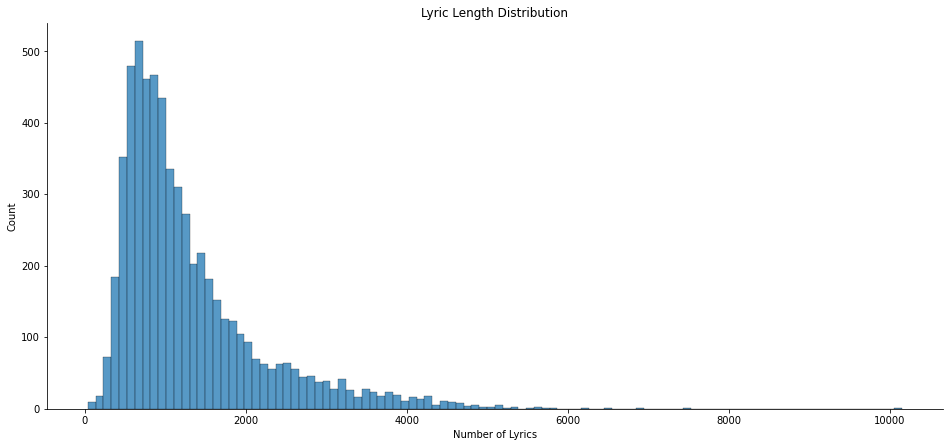

In [83]:
sns.displot(lyrics_lengths)
plt.gcf().set_size_inches(15, 6)
plt.title("Lyric Length Distribution")
plt.xlabel("Number of Lyrics")

In [56]:
results["lemmed"] = train_and_pipeline(lemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.589
Complement NB pipeline test accuracy: 0.599
Random Forest pipeline test accuracy: 0.574
KNN pipeline test accuracy: 0.353


# Stemming

In [57]:
def clean_docs_stemma(lyrics_list):
    cleaned = []
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    for lyric in lyrics_list:
        clean_lyric = nltk.regexp_tokenize(lyric, pattern)
        lyric_lower = [i.lower() for i in clean_lyric]
        stop_words = stopwords.words('english')
        stopwords_list = stop_words + list(string.punctuation)
        stopwords_list += ["''", '""', '...', '``']
        lyrics_tokens_stopped = [w for w in lyric_lower if not w in stopwords_list]
        lyric_stemmas = [stemmer.stem(word) for word in lyrics_tokens_stopped]
        c = " ".join(lyric_stemmas)
        cleaned.append(c)
    return cleaned

In [58]:
stemmed_lyrics = clean_docs_stemma(lyrics_list)

In [59]:
results["stemmed"] = train_and_pipeline(stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.551
Complement NB pipeline test accuracy: 0.585
Random Forest pipeline test accuracy: 0.561
KNN pipeline test accuracy: 0.379


# Stemmed & Lemmatized

In [60]:
lemmatized_stemmed_lyrics = clean_docs_lemma(stemmed_lyrics)

In [61]:
results["lemmatized_stemmed"] = train_and_pipeline(lemmatized_stemmed_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.572
Complement NB pipeline test accuracy: 0.583
Random Forest pipeline test accuracy: 0.601
KNN pipeline test accuracy: 0.377


In [62]:
stemmed_lemmatized_lyrics = clean_docs_lemma(lemmed_lyrics)

In [63]:
results["stemmed_lemmatized"] = train_and_pipeline(stemmed_lemmatized_lyrics)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', MultinomialNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', ComplementNB())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])
Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('clf', KNeighborsClassifier())])
Multinomail NB pipeline test accuracy: 0.558
Complement NB pipeline test accuracy: 0.570
Random Forest pipeline test accuracy: 0.555
KNN pipeline test accuracy: 0.368


In [64]:
results

Counter({'lemmed': [('Multinomail NB', 0.5886666666666667),
          ('Complement NB', 0.5993333333333334),
          ('Random Forest', 0.574),
          ('KNN', 0.3526666666666667)],
         'stemmed': [('Multinomail NB', 0.5506666666666666),
          ('Complement NB', 0.5846666666666667),
          ('Random Forest', 0.5613333333333334),
          ('KNN', 0.37866666666666665)],
         'lemmatized_stemmed': [('Multinomail NB', 0.572),
          ('Complement NB', 0.5826666666666667),
          ('Random Forest', 0.6013333333333334),
          ('KNN', 0.37666666666666665)],
         'stemmed_lemmatized': [('Multinomail NB', 0.558),
          ('Complement NB', 0.57),
          ('Random Forest', 0.5546666666666666),
          ('KNN', 0.368)]})

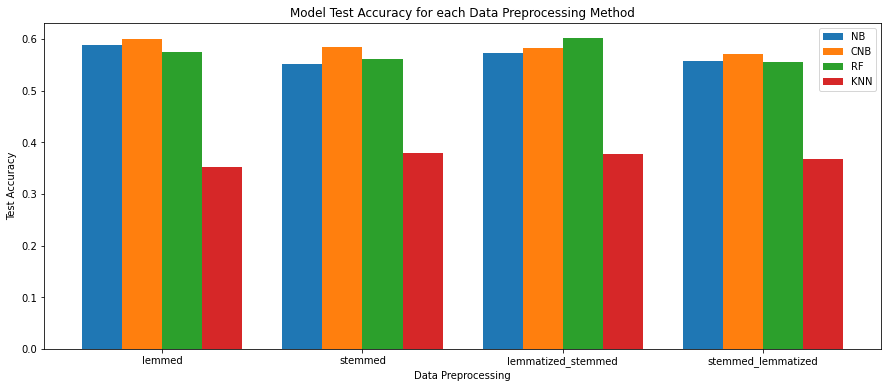

In [65]:
X = results.keys()

MNB = [results[x][0][1] for x in X]
CNB = [results[x][1][1] for x in X]
RF = [results[x][2][1] for x in X]
KNN = [results[x][3][1] for x in X]

X_axis = np.arange(len(X))
plt.bar(X_axis - 0.3, MNB, 0.2, label = 'NB')
plt.bar(X_axis - 0.1, CNB, 0.2, label = 'CNB')
plt.bar(X_axis + 0.1, RF, 0.2, label = 'RF')
plt.bar(X_axis + 0.3, KNN, 0.2, label = 'KNN')

plt.xticks(X_axis, X)

plt.gcf().set_size_inches(15, 6)
plt.xlabel("Data Preprocessing")
plt.ylabel('Test Accuracy')
plt.title("Model Test Accuracy for each Data Preprocessing Method")
plt.legend()
plt.show()

In [ ]:
# Based on the results -> 

In [181]:
X_train, X_test, y_train, y_test = train_test_split(lemmed_lyrics, combined_genre_data.Genres, test_size=0.25) 

# Random Forest Classifier

In [182]:
rfc = RandomForestClassifier()

In [ ]:
GS_pipe_RF = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', RandomForestClassifier())
                    ])

rf_param_grid = dict(clf__n_estimators = [10, 30, 100],
                  clf__criterion = ['gini', 'entropy'],
                  clf__max_depth = [2, 6, 10], 
                  clf__min_samples_split = [5, 10],
                  clf__min_samples_leaf = [3, 6])


gs_RF = GridSearchCV(estimator=GS_pipe_RF,
            param_grid=rf_param_grid,
            scoring='accuracy',
            cv=3)

gs_RF.fit(X_train, y_train)

In [ ]:
rf_gs_testing_score = gs_RF.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(rf_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_RF.best_params_))

# Naive Bayes

In [ ]:
GS_pipe_NB = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', MultinomialNB())
                    ])


sorted(GS_pipe_NB.get_params().keys())

nb_param_grid = dict(clf__alpha = [.01, .05, .1, .2, .4, 1])

gs_NB = GridSearchCV(estimator=GS_pipe_NB,
            param_grid=nb_param_grid,
            scoring='accuracy',
            cv=3)

gs_NB.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [0.01, 0.05, 0.1, 0.2, 0.4, 1]},
             scoring='accuracy')

In [ ]:
nb_gs_testing_score = gs_NB.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(nb_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_NB.best_params_))

Mean Testing Score: 61.27%
Best Parameter Combination Found During Grid Search: 
{'clf__alpha': 0.05}


# KNN Classifier

In [ ]:
GS_pipe_KNN = Pipeline([('count_vectorizer', CountVectorizer()), 
                     ('tfidf_vectorizer', TfidfTransformer()),
                     ('clf', KNeighborsClassifier())
                    ])

knn_param_grid = dict(clf__n_neighbors = [100, 150, 200],
                     clf__p = [1, 2])

gs_KNN = GridSearchCV(estimator=GS_pipe_KNN,
            param_grid=knn_param_grid,
            scoring='accuracy',
            cv=3)

gs_KNN.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('count_vectorizer', CountVectorizer()),
                                       ('tfidf_vectorizer', TfidfTransformer()),
                                       ('clf', KNeighborsClassifier())]),
             param_grid={'clf__n_neighbors': [100, 150, 200], 'clf__p': [1, 2]},
             scoring='accuracy')

In [ ]:
knn_gs_testing_score = gs_KNN.score(X_test, y_test)

print("Mean Testing Score: {:.4}%".format(knn_gs_testing_score * 100))
print("Best Parameter Combination Found During Grid Search: \n{}".format(gs_KNN.best_params_))

Mean Testing Score: 49.2%
Best Parameter Combination Found During Grid Search: 
{'clf__n_neighbors': 200, 'clf__p': 2}
